In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [468]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.000001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
    all_dfs1 = pd.concat(dfs1) 
    preds, labs = all_dfs1['pred'], all_dfs1['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
    df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)

    for d in dfs1:
        plt.scatter(d['label'], d['pred'])
    plt.plot(xy,xy)
    plt.xlabel('Ground truth')
    plt.ylabel('Model prediction')
    plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
             
    return r2_val, df_fin, all_dfs1  

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [471]:
num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:4]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
 

# RNN setup

In [460]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 2000
num_sims = 80
num_inputs = 5

In [473]:
## running function

def run_exp(trainseqs_old, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_plot(trainseqs, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    tests = [r['test'] for r in res]

    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc': acc_test[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc = fully_trained['test_acc'].mean() 
    fully_trained_test_acc_std = fully_trained['test_acc'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests = [tests[i] for i in fully_trained_idx]
    if len(ft_mods) > 0:
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests)
    else:
        r2, dfs, alldfs = 0, 0, 0

    t3 = time.time()
    print('total time: ', (t3-t1)/60)
    print(fully_trained.shape[0], '/', final_accs.shape[0], ' rnns trained to 100% accuracy.\
        \n Mean test acc = ', round(fully_trained_test_acc, 2),  '\n-----------\n')

    return {'res':res, 'r2': r2, 'all_final_accs': final_accs, 'mean_acc_final': fully_trained_test_acc,\
            'all_dfs':alldfs, 'df_trials': dfs, 'acc_std': fully_trained_test_acc_std}

def run_self_other(num_inputs, p=[]):

    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]

    num_other = list(range(0, num_inputs+1))
    num_other.remove(1)

    all_r2s = []
    all_accs = []
    all_reses = []
    all_acc_std = []
    for i in range(len(num_other)):
        n_other = num_other[i]
        print('no. other trials = ', n_other, ';  no. self: ', num_inputs - n_other)
        self_trials = []
        other_trials = []
        if n_other != num_inputs:
            self_trials = generate_self(ops, all_syms[n_other:])
        if n_other != 0:
            other_trials = generate_other(ops, all_syms[:n_other])

        trainseqs = self_trials + other_trials + p
        testseqs = generate_trials(ops, all_syms, all_syms)
        testseqs = [t for t in testseqs if t not in trainseqs]
        print('trainseqs: ', trainseqs)
        print('testseqs: ', testseqs)
        res = run_plot(trainseqs, testseqs, cue_dict)
        all_r2s.append(res['r2'])
        all_accs.append(res['mean_acc_final'])
        all_acc_std.append(res['acc_std'])
        all_reses.append(res)
        
    return all_reses, np.array(all_accs), all_r2s, np.array(all_acc_std)


# Experiments

Final accuracy against ratio of other/self



## Num inputs = 2

In [418]:
ops = '+'
num_inputs = 2

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
#p = generate_primitives(['B'])
p = []
print(p)

{'A': 15, 'B': 3}
[]


trainseqs:  [['A', ('+', 'A'), '=', 14], ['B', '=', 14]]
testseqs:  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'A'), '=', 21], ['B', ('+', 'B'), '=', 28]]
run time:  1.5883120020230612
80
total time:  1.5966588179270427
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.05 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'B', '=']",18.175,21.969890,0.1000
"['B', '+', 'A', '=']",18.175,29.920278,0.0250
"['B', '+', 'B', '=']",17.875,33.404210,0.0125


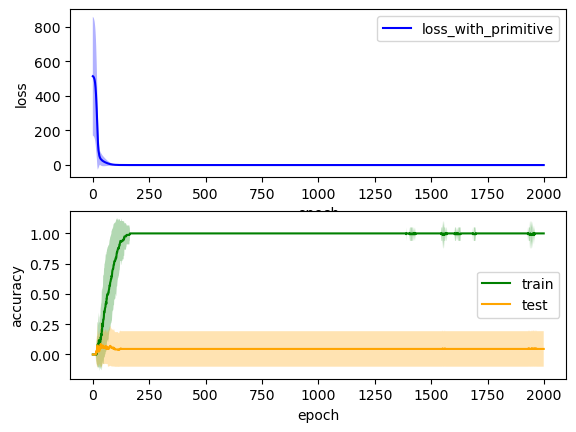

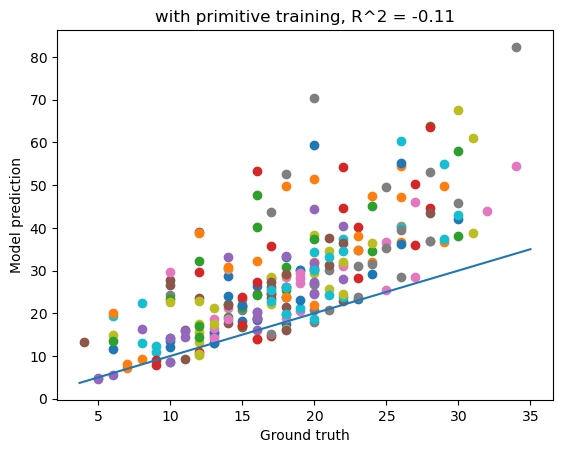

In [412]:
# 1 
trainseqs = generate_self(ops, 'A') + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['B', ('+', 'A'), '=', 21], ['B', '=', 14]]
testseqs:  [['A', ('+', 'A'), '=', 14], ['A', ('+', 'B'), '=', 21], ['B', ('+', 'B'), '=', 28]]
run time:  1.6180684129397074
79
total time:  1.6226341168085734
79 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.12 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'B', '=']",20.075949,19.023987,0.253165
"['B', '+', 'B', '=']",20.101266,22.044335,0.063291
"['A', '+', 'A', '=']",20.050633,17.043705,0.037975


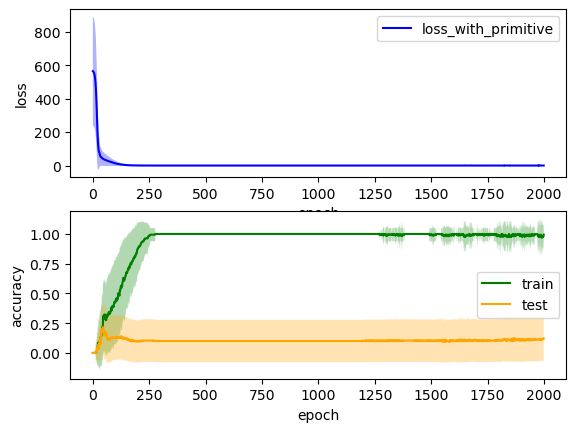

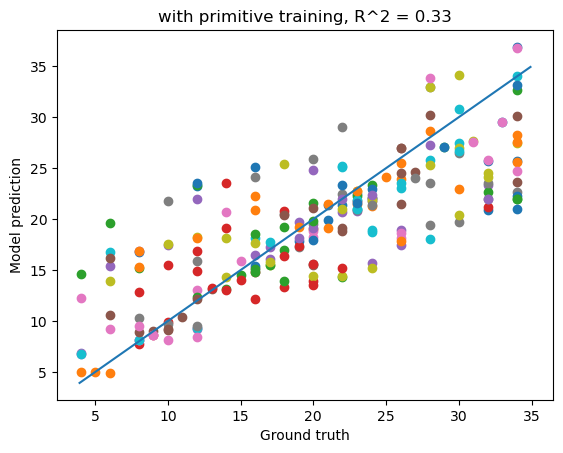

In [413]:
# 2
trainseqs = [generate_other(ops, all_syms)[1]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res2 = run_plot(trainseqs, testseqs, cue_dict)
res2['df_trials']

trainseqs:  [['A', ('+', 'A'), '=', 14], ['B', ('+', 'B'), '=', 28], ['B', '=', 14]]
testseqs:  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'A'), '=', 21]]
run time:  1.9128724495569864
79
total time:  1.9162283817927042
79 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.16 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'B', '=']",20.012658,20.923445,0.164557
"['B', '+', 'A', '=']",20.012658,19.135459,0.164557


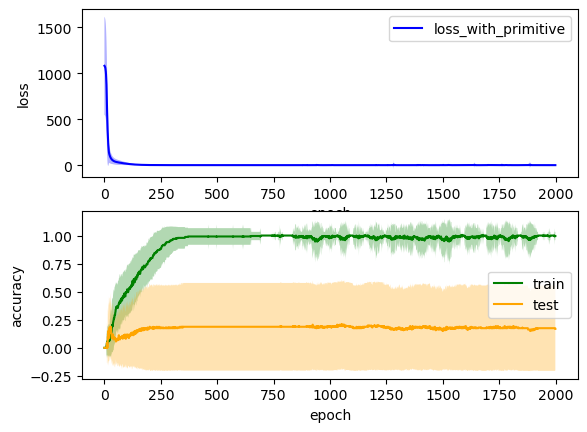

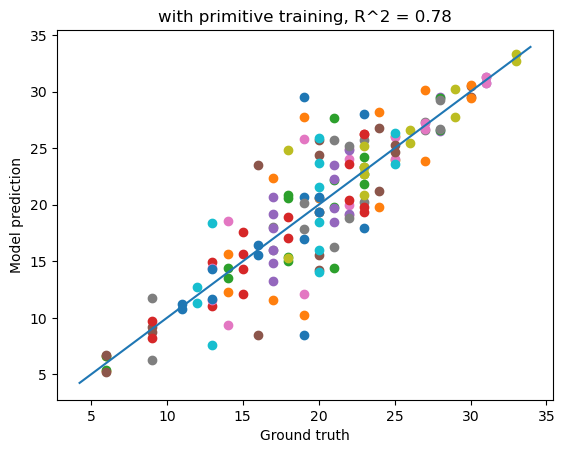

In [414]:
# 3
trainseqs = generate_self(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res3 = run_plot(trainseqs, testseqs, cue_dict)
res3['df_trials']

trainseqs:  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'A'), '=', 21], ['B', '=', 14]]
testseqs:  [['A', ('+', 'A'), '=', 14], ['B', ('+', 'B'), '=', 28]]
run time:  2.031119000911713
77
total time:  2.035076347986857
77 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'A', '=']",19.454545,19.190482,0.0
"['B', '+', 'B', '=']",20.311688,20.548380,0.0


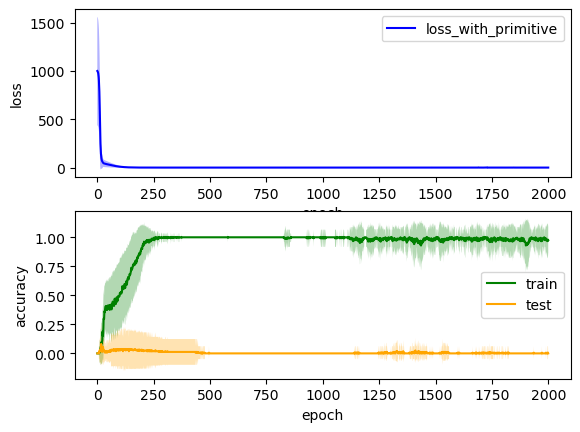

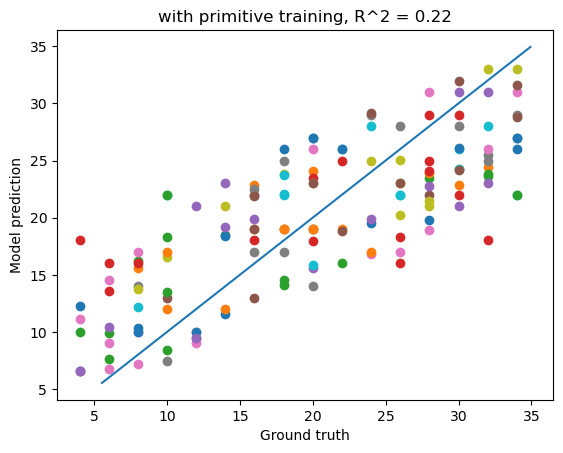

In [415]:
# 4
trainseqs = generate_other(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res4 = run_plot(trainseqs, testseqs, cue_dict)
res4['df_trials']

trainseqs:  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'A'), '=', 21], ['B', ('+', 'B'), '=', 28], ['B', '=', 14]]
testseqs:  [['A', ('+', 'A'), '=', 14]]
run time:  2.3984471996625265
71
total time:  2.4008113781611127
71 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.93 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'A', '=']",17.661972,17.726828,0.929577


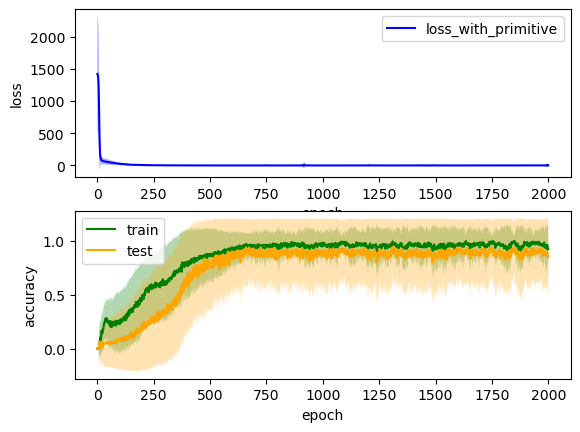

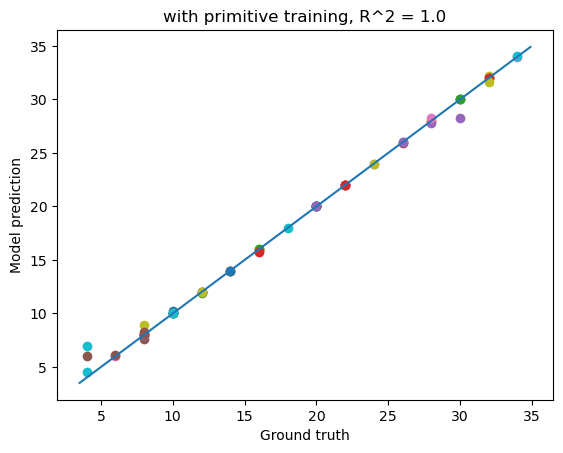

In [416]:
# 5
trainseqs = generate_other(ops, all_syms) + [generate_self(ops, all_syms)[1]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res5 = run_plot(trainseqs, testseqs, cue_dict)
res5['df_trials']

trainseqs:  [['A', ('+', 'A'), '=', 14], ['B', ('+', 'B'), '=', 28], ['B', ('+', 'A'), '=', 21], ['B', '=', 14]]
testseqs:  [['A', ('+', 'B'), '=', 21]]
run time:  2.448462549845378
64
total time:  2.4507532835006716
64 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.91 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'B', '=']",18.140625,17.976143,0.90625


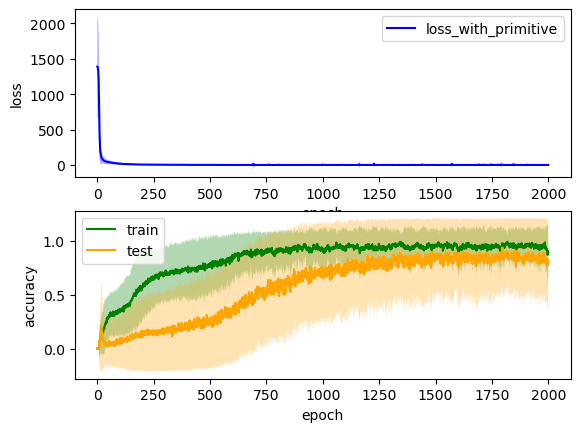

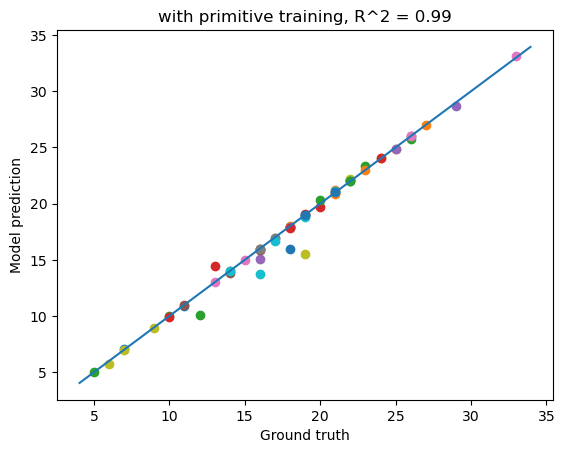

In [417]:
# 6
trainseqs = generate_self(ops, all_syms) + [generate_other(ops, all_syms)[1]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res6 = run_plot(trainseqs, testseqs, cue_dict)
res6['df_trials']

trainseqs:  [['A', ('+', 'B'), '=', 18], ['A', ('+', 'A'), '=', 30]]
testseqs:  [['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 6]]
run time:  1.5451059182484945
80
total time:  1.5490883191426594
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------



,label,pred,acc
trial,,,
"['B', '+', 'A', '=']",18.5625,23.917643,0.0
"['B', '+', 'B', '=']",18.2000,23.663859,0.0


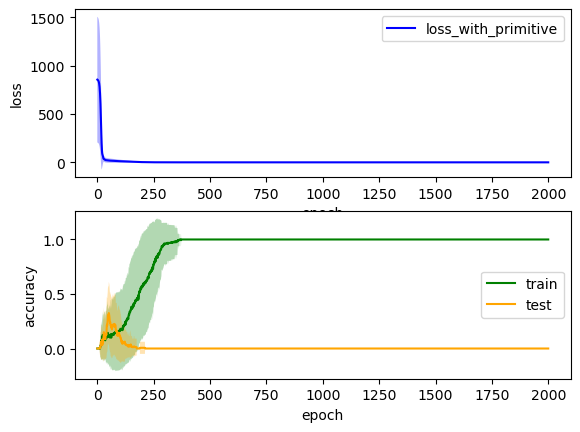

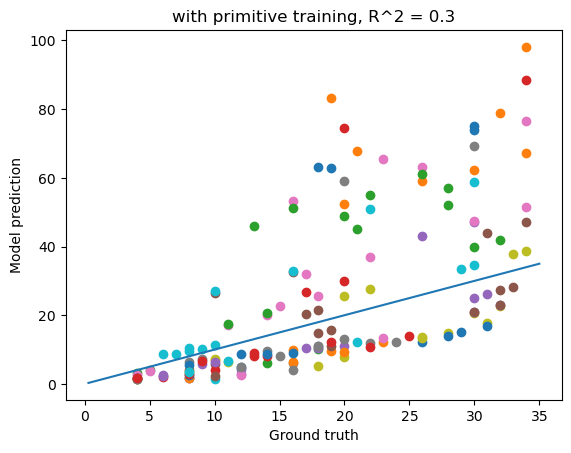

In [420]:
# 7
trainseqs = [generate_other(ops, all_syms)[0]] + [generate_self(ops, all_syms)[0]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res7 = run_plot(trainseqs, testseqs, cue_dict)
res7['df_trials']

trainseqs:  [['A', ('+', 'B'), '=', 18], ['A', ('+', 'A'), '=', 30], ['B', '=', 3]]
testseqs:  [['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 6]]
run time:  2.0154239654541017
79
total time:  2.0191235343615213
79 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.01 
-----------



,label,pred,acc
trial,,,
"['B', '+', 'A', '=']",19.518987,22.548117,0.012658
"['B', '+', 'B', '=']",19.417722,22.560404,0.012658


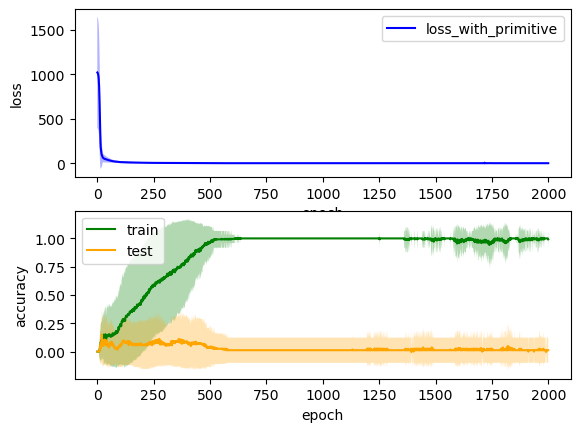

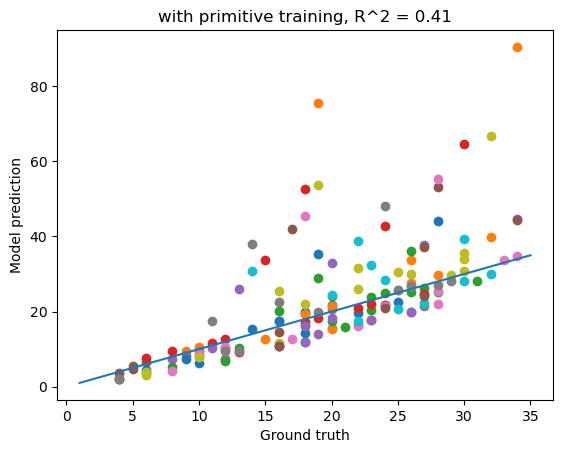

In [422]:
# 7
trainseqs = [generate_other(ops, all_syms)[0]] + [generate_self(ops, all_syms)[0]] + generate_primitives(['B'])
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res7 = run_plot(trainseqs, testseqs, cue_dict)
res7['df_trials']